<h1>Nigerian Political Tweets</h1>
<h2> Sentiment analysis </h2>

<a id="0"></a>

### Content  

* <a href='#1'>Analysis preparation</a>  
* <a href='#2'>Feature engineering</a>  
* <a href='#3'>Sentiment analysis - a data exploration</a>  
* <a href='#4'>Use sentiment polarity features for labeling</a>    
* <a href='#5'>Train a supervised model and validate it</a>    
* <a href='#6'>Conclusions and future work</a>  





## <a id="1">Analysis preparation</a>

We install some missing packages:
* vaderSentiment
* afinn

In [1]:
!pip install vaderSentiment
!pip install afinn

     |████████████████████████████████| 125 kB 284 kB/s 
     |████████████████████████████████| 52 kB 221 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53449 sha256=6467fb7a48d7eeb0ad3806284296f653cb808373f3be943259bd25b5641e1faf
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [2]:
!pip install twython

We then include the packages used for the analysis.

In [3]:
import numpy as np 
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
from nltk.sentiment import SentimentAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import warnings
warnings.simplefilter("ignore")

Following, we load the data.

In [4]:

tweets_df = pd.read_csv('../input/political-news-fake-or-real-nigeria/output.csv')

## <a id="2">Feature engineering</a>


### Text cleaning and preprocessing

Next, we introduce few useful functions for preparing the additional features, as following:
* data cleaning; the data filtered is not presented to the sentiment analysis extraction (we need the full context, including punctuation, for the sentiment analysis tasks).
* text preprocessing - further text transformation: tokenization, eliminate stop words and stemming (same as before, the transformed text will not be presented to the sentiment analysis task;
* further text transformation, using TreebankWordDetokenizer.

In [5]:
def cleaning_data(data):
    data['modi']=data['text'].str.lower()
    i=0
    for x in data['modi']:
        for y in x:
            if y in punctuation:
                data['modi'][i]=data['modi'][i].replace(y,'')
        data['modi'][i]=data['modi'][i].replace('br','')
        i+=1
    data = pd.concat([data.drop(['modi'], axis=1), data['modi'].apply(pd.Series)], axis=1)

In [6]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    porter = PorterStemmer()
    stems = []
    for t in tokens:    
        stems.append(porter.stem(t))
    return stems

Apply text cleaning (filtering), text preprocessing and further text transformation.

In [7]:
cleaning_data(tweets_df)
tweets_df['modi']= tweets_df['modi'].apply(lambda x : preprocess_text(x))
tweets_df['modi']=tweets_df['modi'].apply(lambda x: TreebankWordDetokenizer().detokenize(x))

### Sentiment analysis

First, we define the functions for the sentiment analysis:
- using TextBlob, and obtain sentiment polarity and sentiment subjectivity;
- using vader by nltk SentimentIntensityAnalyzer;
- using Affin.

Then we calculate doc2vec transformation using gensim Doc2Vec and also calculate TF-IDF on the modified form of the text data (text that was subjcted to text cleaning and pre-processing).


In [8]:
def find_sentiment_polarity_textblob(text):
    blob = TextBlob(text)
    polarity = 0
    for sentence in blob.sentences:
        polarity += sentence.sentiment.polarity
    return polarity

def find_sentiment_subjectivity_textblob(text):
    blob = TextBlob(text)
    subjectivity = 0
    for sentence in blob.sentences:
        subjectivity += sentence.sentiment.subjectivity
    return subjectivity

In [9]:
def sentiment_scores(data):
    analyser = SentimentIntensityAnalyzer()
    afin = Afinn(emoticons=True)
    data['vader']=data['text'].apply(lambda x : analyser.polarity_scores(x))
    data['afinn']=data['text'].apply(lambda x : afin.score(x))
    data = pd.concat([data.drop(['vader'], axis=1), data['vader'].apply(pd.Series)], axis=1)
    data["tb_pol"] = data["text"].apply(lambda x: find_sentiment_polarity_textblob(x))
    data["tb_sub"] = data["text"].apply(lambda x: find_sentiment_subjectivity_textblob(x))
    data['blob']=data['text'].apply(lambda x : TextBlob(x).sentiment)
    data = pd.concat([data.drop(['blob'], axis=1), data['blob'].apply(pd.Series)], axis=1)
    data['lenght'] = data['text'].apply(lambda x : len(x))
    data['words'] = data['text'].apply(lambda x :len(x.split(" ")))
    return data

In [10]:
def doc2vec(data):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["modi"].apply(lambda x: x.split(" ")))]
    # train a Doc2Vec model with our text data
    model = Doc2Vec(documents, workers=4,vector_size=50,dm=0,min_count = 1)

    # transform each document into a vector data
    doc2vec_df = data["modi"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
    doc2vec_df.columns = ["d2v_" + str(x) for x in doc2vec_df.columns]
    data = pd.concat([data, doc2vec_df], axis=1)
     
    return data

### End to end feature engineering

We apply in the make_features function (see below) the transformations (to calculate sentiment scores and to form the vectorized features from modified text data).

In [11]:
def make_features(data):
    data = sentiment_scores(data)
    data = doc2vec(data)
    
    tfidf = TfidfVectorizer(min_df=10,max_df=0.6,ngram_range=(1,3))
    tfidf.fit(data["modi"])
    tfidf_result = tfidf.transform(data["modi"]).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = data.index
    data = pd.concat([data, tfidf_df], axis=1)

    data.fillna(0,inplace=True)
    return data

In [12]:
x = make_features(tweets_df)

Let's look to the original text, the pre-processed text (`modi`),  extracted sentiment analysis features and few more features extracted (length of initial text, number of words).

In [13]:
selected_columns = ['text', 'modi', 'afinn', 'neg', 'neu', 'pos', 'compound', 'tb_pol', 'tb_sub', 'lenght', 'words']
x[selected_columns].head()

,text,modi,afinn,neg,neu,pos,compound,tb_pol,tb_sub,lenght,words
0,RT @StFreakingKezy: If you to confirm the auth...,rt stfreakingkezi confirm authent inform niger...,0.0,0.0,1.000,0.000,0.0000,0.0,0.00,144,23
1,RT @NigeriaNewsdesk: APC: North Central geo po...,rt nigerianewsdesk apc north central geo polit...,0.0,0.0,0.847,0.153,0.4019,0.0,0.15,130,16
2,RT @NigeriaNewsdesk: APC: North Central geo po...,rt nigerianewsdesk apc north central geo polit...,0.0,0.0,0.847,0.153,0.4019,0.0,0.15,130,16
3,RT @NigeriaNewsdesk: APC: North Central geo po...,rt nigerianewsdesk apc north central geo polit...,0.0,0.0,0.847,0.153,0.4019,0.0,0.15,130,16
4,RT @StFreakingKezy: If you to confirm the auth...,rt stfreakingkezi confirm authent inform niger...,0.0,0.0,1.000,0.000,0.0000,0.0,0.00,144,23


## <a id="3">Sentiment analysis - a data exploration</a>

In [14]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

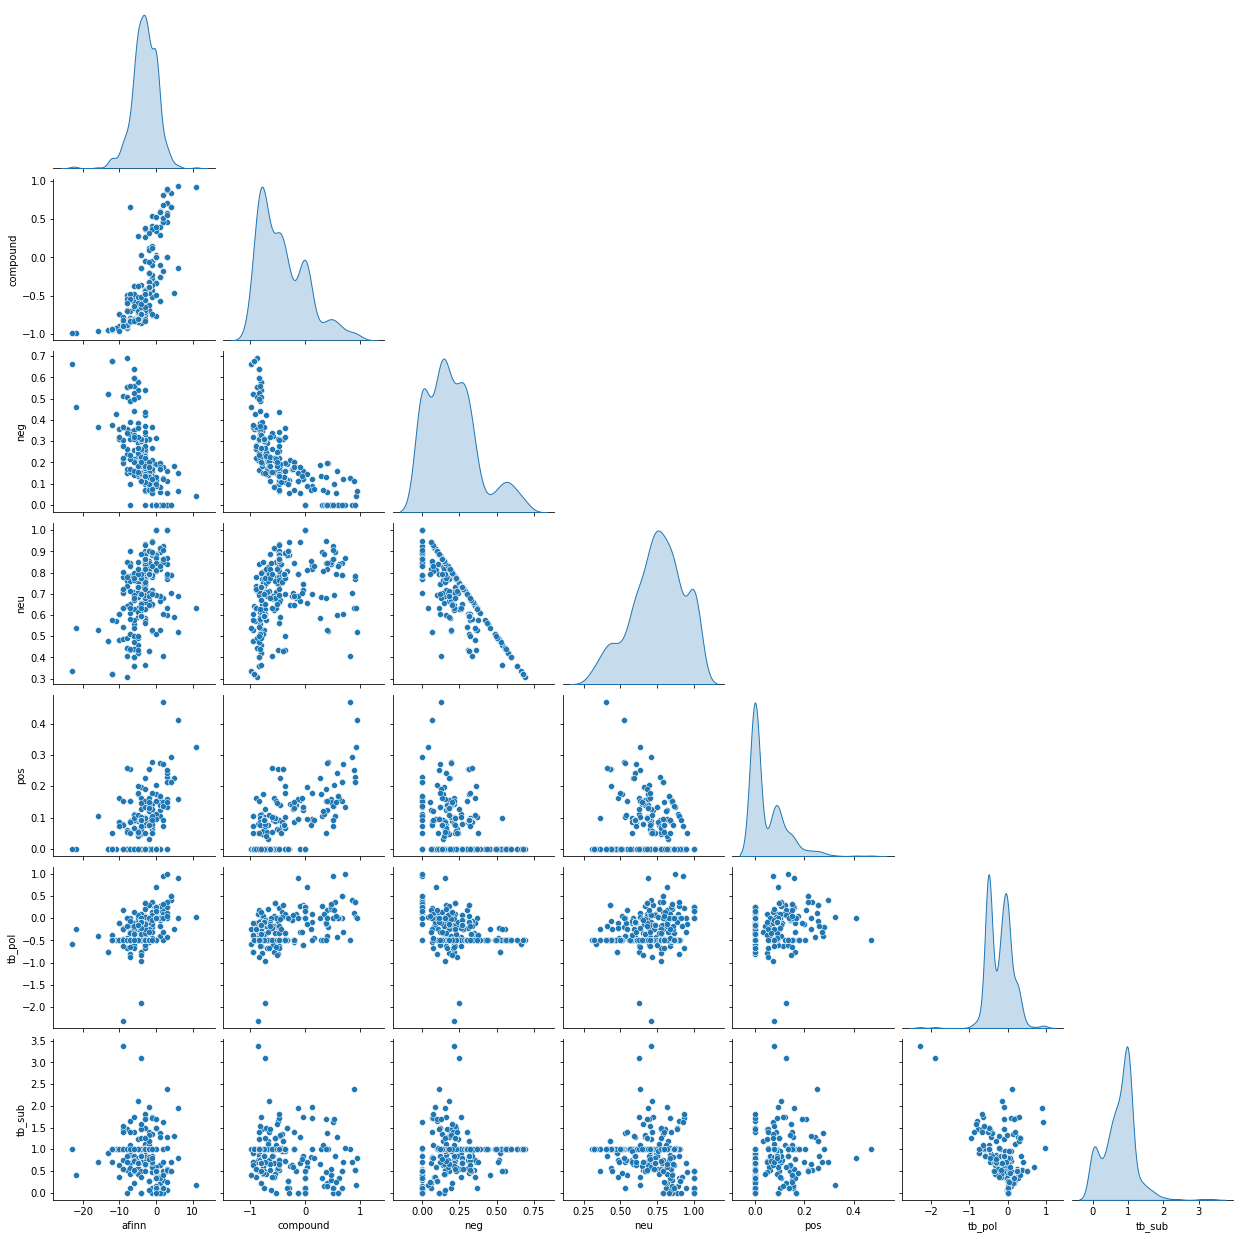

In [15]:
selected = ["afinn", "compound","neg", "neu", "pos","tb_pol", "tb_sub"]
sns.pairplot(x[selected].sample(500), diag_kind="kde", corner=True)

## <a id="4">Use sentiment polarity features for labeling</a>


We will use `compound` feature for labeling, as following:
* if the feature is smaller than 0, we label as `negative` (0) the tweet;
* if the feature is larger than 0, we label as `positive` (1) the tweet.

In [16]:
def label_based_on_compound_value(compound):
    if compound > 0:
        return 1 # positive
    else:
        return 0 # negative

In [17]:
x['label'] = x['compound'].apply(lambda x: label_based_on_compound_value(x))

## <a id="5">Train a supervised model and validate it</a>

We select the columns to include into the model.

In [18]:
ignore_columns = ['id', 'date_created']

We create a train, validation and test set. We select 10% of the data for test set. From the remaining 90%, 90% (or 81% from initial dataset) we use as train and the rest of 10% as validation data.

In [19]:
from sklearn.model_selection import train_test_split
features = [c for c in list(x.columns) if c not in ignore_columns]
train_labels = x['label']
X_train, X_test, y_train, y_test = train_test_split(x[features], train_labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 810 entries, 633 to 695
Columns: 702 entries, Unnamed: 0 to label
dtypes: float32(50), float64(646), int64(4), object(2)
memory usage: 4.2+ MB


In [21]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# prepare input data
def prepare_inputs(X_train, X_test, X_val):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    X_val_enc = oe.transform(X_val)
    return X_train_enc, X_test_enc, X_val_enc
 
# prepare target
def prepare_targets(y_train, y_test, y_val):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    y_val_enc = le.transform(y_val)
    return y_train_enc, y_test_enc, y_val_enc

In [22]:
# prepare input data
X_train_enc, X_test_enc, X_val_enc = prepare_inputs(X_train, X_test, X_val)
# prepare output data
y_train_enc, y_test_enc, y_val_enc = prepare_targets(y_train, y_test, y_val)

In [23]:
print(f"train: {X_train_enc.shape}, test: {X_test_enc.shape}, valid: {X_val_enc.shape}")

train: (810, 702), test: (100, 702), valid: (90, 702)


We import the libraries for the model.

In [24]:
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import optimizers
import keras
from sklearn import metrics

We define the model. Will use (for this baseline) few Dense layers and few Dropouts  layers (to reduce overfitting).

In [25]:
model = Sequential([
    Dense(32, input_shape=(x[features].shape[1],)),
    Activation('relu'),
    Dropout(0.85),
    Dense(16),
    Activation('relu'),
    Dropout(0.55),
    Dense(1),
    Activation('sigmoid'),
])

Let's glimpse the model structure.

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                22496     
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

We prepare now to fit the model. We will use as well validation data during model training. We train for 100 epochs.

In [27]:
model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
no_epoch = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
an = LearningRateScheduler(lambda x: 1e-3 * 0.991 ** (x+no_epoch))
ck = ModelCheckpoint('best_model.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True)


In [29]:
model_history = model.fit(X_train_enc,y_train_enc,validation_data=(X_val_enc, y_val_enc), epochs=no_epoch, batch_size=64,verbose = 1, callbacks = [es, an, ck])

Epoch 1/50
13/13 [==============================] - 1s 58ms/step - loss: 66.9403 - accuracy: 0.7410 - val_loss: nan - val_accuracy: 0.8778
Epoch 2/50
13/13 [==============================] - 0s 7ms/step - loss: 32.6397 - accuracy: 0.7633 - val_loss: nan - val_accuracy: 0.8778
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 12.2268 - accuracy: 0.8407 - val_loss: nan - val_accuracy: 0.8778
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 7.2315 - accuracy: 0.8347 - val_loss: nan - val_accuracy: 0.8778
Epoch 5/50
13/13 [==============================] - 0s 7ms/step - loss: 2.0649 - accuracy: 0.8538 - val_loss: nan - val_accuracy: 0.8778
Epoch 00005: early stopping


Let's verify accuracy of inference using the trained model for: train, validation and test data.

In [30]:
print("Test:", model.evaluate(X_test_enc,y_test_enc))
print("Valid:", model.evaluate(X_val_enc,y_val_enc))
print("Train:", model.evaluate(X_train_enc,y_train_enc))

4/4 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8700
Test: [nan, 0.8700000047683716]
3/3 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.8778
Valid: [nan, 0.8777777552604675]
26/26 [==============================] - 0s 1ms/step - loss: 0.4166 - accuracy: 0.9000
Train: [0.4166310727596283, 0.8999999761581421]


In [31]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools, subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = subplots.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(model_history)

In [32]:
def test_accuracy_report(model, X, y, title=""):
    print(title)
    predicted = model.predict(X)
    predicted = np.round(predicted)
    truth = y
    print(metrics.classification_report(truth, predicted, target_names=["Negative", "Positive"])) 
    res = model.evaluate(X, y, verbose=0)
    print('Loss function: %s, accuracy:' % res[0], res[1])

In [33]:
# test_accuracy_report(model, X_test_enc, y_test_enc, "Test set (how well model generalize for fresh data)")

In [34]:
# test_accuracy_report(model, X_val_enc, y_val_enc, "Validation set (how well model perform with validation data)")

In [35]:
test_accuracy_report(model, X_train_enc, y_train_enc, "Train set (how well model learns its own data)")

Train set (how well model learns its own data)
              precision    recall  f1-score   support

    Negative       0.90      1.00      0.95       723
    Positive       0.80      0.09      0.16        87

    accuracy                           0.90       810
   macro avg       0.85      0.54      0.56       810
weighted avg       0.89      0.90      0.86       810

Loss function: 0.4166310727596283, accuracy: 0.8999999761581421


## <a id="6">Conclusions and future work</a>


### Conclusions

We used sentiment analysis libraries to calculate negtive, positive, neutral, respective polarity and subjectivity of sentiment. We used the compound factor from {postive, negative, neutral} sentiment score to label data.
We split available data in train, validation and test data.
We used train and validation data to train and validate a model.

Then we checked the accuracy of prediction on test data (not used during training or validation) with the trained model.
We obtained a **84%** accuracy of the sentiment polarity score prediction.

### Future work

We will manually label data for better performance of the training. We will train a model with the manual labeled data and apply the model to predict sentiment score for the new data, not used in the train. We will analyze next the correlation between the sentiment score obtained using pre-trained models from libraries with the sentiment obtained by applying the model.
The model itself can be further much improve by using the following techniques:
- Use a DL model with word embeddings Bidirectional LSTM layers;
- Use a transformed type model;